<a href="https://colab.research.google.com/github/southjohn64/data_mine/blob/main/Copy_of_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework Assignment  5

In [1]:
!pip install turicreate

     |████████████████████████████████| 92.0 MB 1.2 MB/s 
     |████████████████████████████████| 322 kB 58.6 MB/s 
     |████████████████████████████████| 3.6 MB 54.2 MB/s 
     |████████████████████████████████| 86.4 MB 72 kB/s 
     |████████████████████████████████| 3.5 MB 38.5 MB/s 
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
     |████████████████████████████████| 449 kB 61.4 MB/s 
     |████████████████████████████████| 2.9 MB 50.4 MB/s 
     |████████████████████████████████| 3.8 MB 48.8 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Created wheel for prettytable: filename=prettytable-0.7.2-py3-none-any.whl size=13714 sha256=1d7ed8523a154cb1d9e5afa12b699cfd102a448346e46f3d16696a2594c1264e
  Stored in directory: /root/.cache/pip/wheels/b2/7f/f6/f180315b584f00445045ff1699b550fa895d09471337ce21c6
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320860 sha256=bac60a7602

In [2]:
# features of link to sframe
import networkx as nx
import turicreate as tc 

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [3]:
# read data
'FAA Preferred Routes (2010)'
'https://downloads.skewed.de/mirror/konect.cc/files/download.tsv.maayan-faa.tar.bz2'
!mkdir ./datasets/
!mkdir ./datasets/flight
!wget https://downloads.skewed.de/mirror/konect.cc/files/download.tsv.maayan-faa.tar.bz2 -O ./datasets/flight/flight.tar.bz2
!tar -xf ./datasets/flight/flight.tar.bz2 -C ./datasets/flight/
!ls ./datasets/flight/

--2021-11-23 13:52:27--  https://downloads.skewed.de/mirror/konect.cc/files/download.tsv.maayan-faa.tar.bz2
Resolving downloads.skewed.de (downloads.skewed.de)... 49.12.93.194
Connecting to downloads.skewed.de (downloads.skewed.de)|49.12.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9549 (9.3K) [application/x-bzip2]
Saving to: ‘./datasets/flight/flight.tar.bz2’

./datasets/flight/f 100%[===================>]   9.33K  --.-KB/s    in 0s      

2021-11-23 13:52:27 (184 MB/s) - ‘./datasets/flight/flight.tar.bz2’ saved [9549/9549]

flight.tar.bz2	maayan-faa


In [4]:
#parsing data
from_array = []
to_array = []
graph_dic = {'from_node': from_array, 'to_node': to_array}

filename = '/content/datasets/flight/maayan-faa/out.maayan-faa'
line_num = 0
with open(filename) as file:
    for line in file:
        if line_num > 0:
            from_array.append(line.rstrip().split(' ')[0])
            to_array.append(line.rstrip().split(' ')[1])
            
        line_num += 1

print('from_array: ', len(from_array))
print('to_array: ', len(to_array))

from_array:  2615
to_array:  2615


In [5]:
sf = tc.SFrame(graph_dic)
sf

from_node,to_node
1,2
2,3
3,4
4,5
1,6
6,7
7,8
8,9
6,10
10,11


In [6]:
directed_graph_nx = nx.DiGraph()
directed_graph_nx.add_edges_from([(r['from_node'],r['to_node']) for r in sf])
print(nx.info(directed_graph_nx))

DiGraph with 1226 nodes and 2615 edges


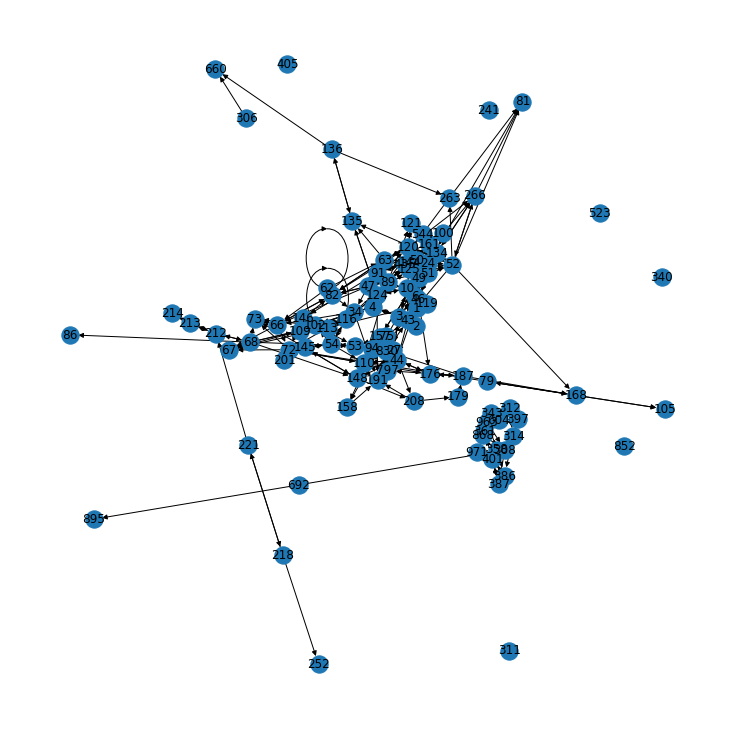

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

l = [n for n,degree in dict(directed_graph_nx.degree()).items() if degree > 10]
h = directed_graph_nx.subgraph(l)
plt.figure(figsize=(10,10))
#nx.write_gml(h, "./datasets/enron/maildir/network.gml")
nx.draw_spring(h, with_labels=True)

In [9]:
import operator
def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set


def rank_friends_of_friends(g, v, top_n):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)[:top_n]
    sorted_d = [a for a in sorted_d if a[1]>0 ]

    return sorted_d

In [10]:
# i showing only nodes with rank above 0 and only topN node
rank_friends_of_friends(directed_graph_nx, '1', top_n=10)

[('43', 3),
 ('3', 3),
 ('134', 2),
 ('49', 2),
 ('21', 1),
 ('51', 1),
 ('7', 1),
 ('124', 1),
 ('144', 1)]

In [11]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm 

In [12]:
g = nx.Graph() # Creating Undirected Graph
# adding all nodes and vertices at once
g.add_edges_from([(r['from_node'],r['to_node']) for r in sf])
print(nx.info(g))

Graph with 1226 nodes and 2410 edges


In [13]:
# This is for predicting missing links scenario
import random 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
postive_links = select_random_existing_links(directed_graph_nx,1000)
negative_links = select_random_non_existing_links(directed_graph_nx,1000)

In [14]:
def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            'friends_measure': friends_measure(g, u,v)
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)
links_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

{'adamic_adar_index': 0,
 'class': True,
 'common_friends': 0,
 'degree_u': 2,
 'degree_v': 0,
 'friends_measure': 0,
 'jaccard_coefficient': 0.0,
 'total_friends': 2}

In [15]:
import turicreate as tc
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure', 'class' ]
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

adamic_adar_index,class,common_friends,degree_u,degree_v,friends_measure,jaccard_coefficient,total_friends
0.0,1,0,2,0,0,0.0,2
0.0,1,0,1,2,10,0.0,3
0.0,1,0,2,2,2,0.0,4
0.0,1,0,2,9,31,0.0,11
0.0,1,0,9,6,8,0.0,15
0.0,1,0,19,1,4,0.0,20
0.0,1,0,5,2,3,0.0,7
1.7702466315385705,1,4,23,17,264,0.1111111111111111,36
0.0,1,0,2,12,71,0.0,14
0.0,1,0,1,12,5,0.0,13


In [16]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'jaccard_coefficient', 'adamic_adar_index', 'friends_measure' ]
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1602
Test size: 398
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1521

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.005319     | 0.842209          | 0.864198            | 0.558009          | 0.551221            |

| 2         | 0.012522     | 0.850756          | 0.864198            | 0.479800          | 0.471785            |

| 3         | 0.016659     | 0.855358          | 0.864198            | 0.429677          | 0.422130            |

| 4         | 0.020598     | 0.854701          | 0.864198            | 0.395349          | 0.388180            |

| 5         | 0.025478     | 0.855358          | 0.876543            | 0.370809          | 0.363702            |

| 10        | 0.047482     | 0.867850          | 0.888889            | 0.311643          | 0.339765            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1521

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.007101     | 0.840894          | 0.864198            | 0.398231          | 0.377782            |

| 2         | 0.010489     | 0.844181          | 0.888889            | 0.395640          | 0.369326            |

| 3         | 0.014632     | 0.844839          | 0.888889            | 0.393079          | 0.367766            |

| 4         | 0.018046     | 0.849441          | 0.876543            | 0.402409          | 0.373595            |

| 5         | 0.022535     | 0.846811          | 0.876543            | 0.406821          | 0.378656            |

| 10        | 0.039307     | 0.846154          | 0.876543            | 0.412907          | 0.376959            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1521

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.004852     | 0.842209          | 0.864198            | 0.392924          | 0.385028            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1521

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients    : 8

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.002593     | 0.497041          | 0.555556            |

| 1         | 5        | 5.000000  | 0.008171     | 0.670611          | 0.654321            |

| 2         | 6        | 5.000000  | 0.010044     | 0.581854          | 0.580247            |

| 3         | 11       | 1.404453  | 0.018108     | 0.672584          | 0.654321            |

| 4         | 16       | 0.802442  | 0.024864     | 0.700197          | 0.728395            |

| 9         | 29       | 0.838234  | 0.052943     | 0.717291          | 0.728395            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1521

Number of classes           : 2

Number of feature columns   : 7

Number of unpacked features : 7

Number of coefficients      : 8

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.005857     | 0.719264          | 0.765432            |

| 2         | 3        | 0.012911     | 0.722551          | 0.753086            |

| 3         | 4        | 0.020242     | 0.725181          | 0.765432            |

| 4         | 5        | 0.024552     | 0.726496          | 0.765432            |

| 5         | 6        | 0.030518     | 0.725838          | 0.765432            |

| 6         | 7        | 0.039202     | 0.725838          | 0.765432            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8888888888888888
PROGRESS: RandomForestClassifier          : 0.8765432098765432
PROGRESS: DecisionTreeClassifier          : 0.8641975308641975
PROGRESS: SVMClassifier                   : 0.7283950617283951
PROGRESS: LogisticClassifier              : 0.7654320987654321
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [18]:
results = cls.evaluate(test)
results

{'accuracy': 0.7989949748743719,
 'auc': 0.8708744728668469,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |   39  |
 |      1       |        1        |  160  |
 |      0       |        1        |   41  |
 |      0       |        0        |  158  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.8,
 'log_loss': 0.4489007722529617,
 'precision': 0.7960199004975125,
 'recall': 0.8040201005025126,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 199 | 199 |
 |   0.001   | 1.0 | 1.0 | 199 | 199 |
 |   0.002   | 1.0 | 1.0 | 199 | 199 |
 |   0.

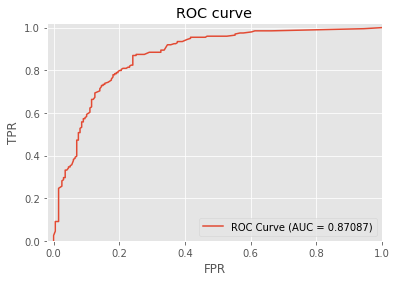

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.plot(results['roc_curve']['fpr'],
         results['roc_curve']['tpr'],
         label='ROC Curve (AUC = %0.5f)' %results['auc'])

plt.xlim([-0.02, 1.0])
plt.ylim([0., 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

In [20]:
!pip install karateclub

     |████████████████████████████████| 62 kB 716 kB/s 
     |████████████████████████████████| 1.8 MB 15.2 MB/s 
     |████████████████████████████████| 24.1 MB 1.5 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.2-py3-none-any.whl size=97744 sha256=d735fc168bd6e1900e82e00692f1b5ae9b61b4493e15f28aa3232e2aad2c10eb
  Stored in directory: /root/.cache/pip/wheels/14/4b/99/abc777e42da28bc43b6959267f4f1c5eee06814a5c608a9ed2
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149866 sha256=38ab3fe160d678ce8a2d00425b4a9b5b44466f9675434ed72c6c8a4850fc2c81
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built karateclub python-Levenshtein
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [22]:
train_df = train.to_dataframe()
train_df

,adamic_adar_index,class,common_friends,degree_u,degree_v,friends_measure,jaccard_coefficient,total_friends
0,0.0,1,0,1,2,10,0.0,3
1,0.0,1,0,2,2,2,0.0,4
2,0.0,1,0,9,6,8,0.0,15
3,0.0,1,0,19,1,4,0.0,20
4,0.0,1,0,5,2,3,0.0,7
...,...,...,...,...,...,...,...,...
1597,0.0,0,0,10,1,3,0.0,11
1598,0.0,0,0,1,3,0,0.0,4
1599,0.0,0,0,7,3,0,0.0,10
1600,0.0,0,0,6,9,121,0.0,15


In [24]:
import karateclub

model = karateclub.DeepWalk()

model.fit(train_df)
embedding = model.get_embedding()

AttributeError: ignored

**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    